In [1]:
%matplotlib inline
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from PIL import Image

import librosa 
import librosa.display 
import librosa.feature

import os 

from sklearn.feature_selection import VarianceThreshold
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score ,recall_score, f1_score, zero_one_loss, classification_report
from sklearn.preprocessing import normalize, StandardScaler,LabelEncoder

import keras
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.utils import to_categorical

import csv
import time
import pathlib

In [42]:
file = open('E:/Project/data.csv', 'w', newline='')
header = 'filename tempo chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

with file:
    writer = csv.writer(file)
    writer.writerow(header)
    

In [43]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']

for g in genres:
    print(f'Genre:{g} started')

    start_time = time.time()

    
    for filename in os.listdir(f'E:/Project/genres/{g}'):
        
        songname = f'E:/Project/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30,sr=None)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rms = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        tempo = float(librosa.beat.tempo(y=y, sr=sr)[0])
        to_append = f'{filename} {tempo} {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('E:/Project/data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())
            

    end_time = time.time()
    duration = end_time - start_time

    print(f'Genre:{g} completed in {duration:.2f} seconds')

print("All genres completed")

Genre:blues started


C:\Users\mihir\AppData\Local\Temp\ipykernel_6624\2885305321.py:21: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = float(librosa.beat.tempo(y=y, sr=sr)[0])


Genre:blues completed in 49.26 seconds
Genre:classical started
Genre:classical completed in 50.40 seconds
Genre:country started
Genre:country completed in 48.74 seconds
Genre:disco started
Genre:disco completed in 49.04 seconds
Genre:hiphop started
Genre:hiphop completed in 49.50 seconds
Genre:jazz started
Genre:jazz completed in 48.80 seconds
Genre:metal started
Genre:metal completed in 49.43 seconds
Genre:pop started
Genre:pop completed in 51.67 seconds
Genre:reggae started
Genre:reggae completed in 51.25 seconds
Genre:rock started
Genre:rock completed in 53.16 seconds
All genres completed


In [44]:
data = pd.read_csv('E:/Project/data.csv')
data.head()

,filename,tempo,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00000.au,123.046875,0.349951,0.130192,1784.416546,2002.657106,3806.418650,0.083066,-113.619385,121.553017,...,8.806787,-3.665802,5.745939,-5.161711,0.750298,-1.688358,-0.409329,-2.298869,1.219947,blues
1,blues.00001.au,107.666016,0.340945,0.095892,1529.871314,2038.612143,3548.986873,0.056044,-207.581512,123.997147,...,5.375942,-2.237833,4.217125,-6.011047,0.932668,-0.717028,0.292333,-0.285717,0.532144,blues
2,blues.00002.au,161.499023,0.363562,0.175494,1552.637786,1747.382028,3041.089944,0.076301,-90.776344,140.448608,...,5.785763,-8.899733,-1.087024,-9.216774,2.453649,-7.721793,-1.816497,-3.434353,-2.231391,blues
3,blues.00003.au,172.265625,0.404848,0.141139,1070.110059,1596.244204,2185.061787,0.033309,-199.462006,150.094727,...,6.085354,-2.476188,-1.076225,-2.876056,0.776909,-3.320055,0.637263,-0.617507,-3.406940,blues
4,blues.00004.au,135.999178,0.308598,0.091540,1835.507009,1748.367477,3581.003346,0.101500,-160.291855,126.195763,...,-2.809849,-6.935621,-7.559294,-9.172152,-4.510408,-5.453736,-0.924468,-4.408076,-11.701833,blues


In [45]:
data = data.drop(['filename'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tempo               1000 non-null   float64
 1   chroma_stft         1000 non-null   float64
 2   rmse                1000 non-null   float64
 3   spectral_centroid   1000 non-null   float64
 4   spectral_bandwidth  1000 non-null   float64
 5   rolloff             1000 non-null   float64
 6   zero_crossing_rate  1000 non-null   float64
 7   mfcc1               1000 non-null   float64
 8   mfcc2               1000 non-null   float64
 9   mfcc3               1000 non-null   float64
 10  mfcc4               1000 non-null   float64
 11  mfcc5               1000 non-null   float64
 12  mfcc6               1000 non-null   float64
 13  mfcc7               1000 non-null   float64
 14  mfcc8               1000 non-null   float64
 15  mfcc9               1000 non-null   float64
 16  mfcc10 

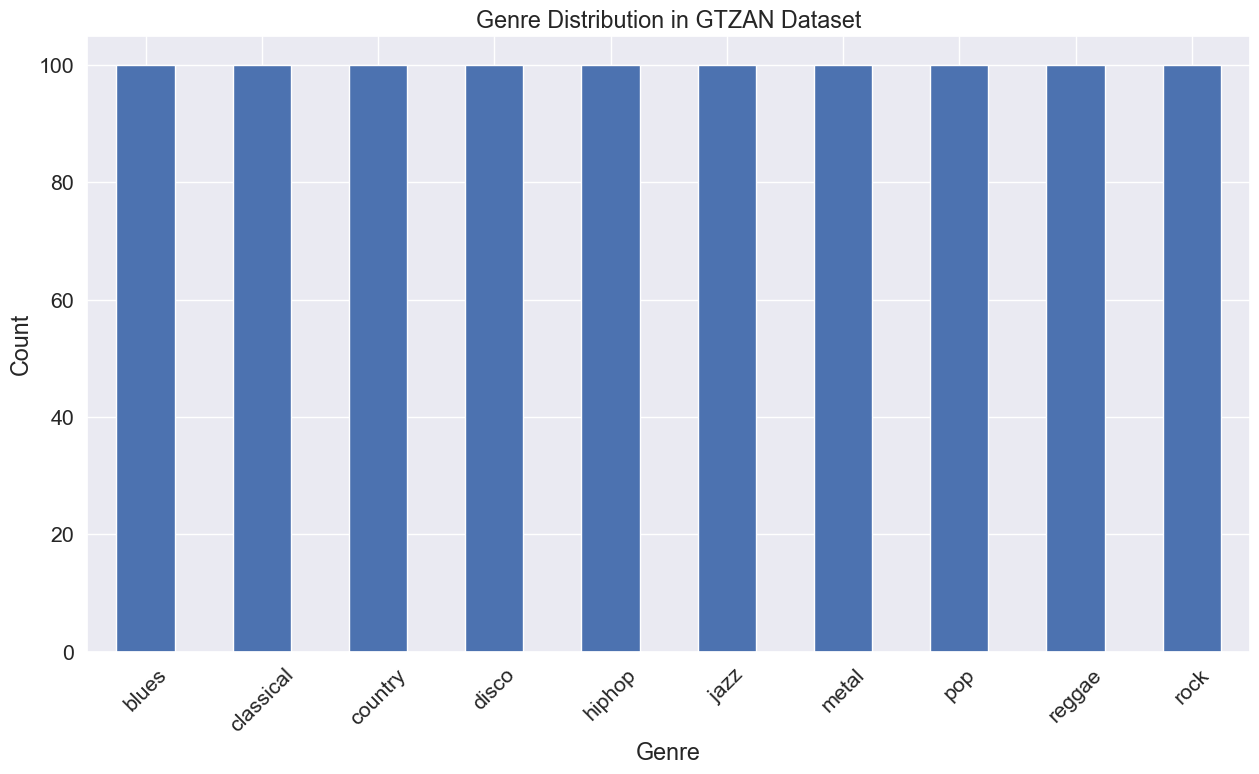

In [52]:
genre_counts = data['label'].value_counts()

plt.figure(figsize=(15, 8))
genre_counts.plot(kind='bar')
plt.title('Genre Distribution in GTZAN Dataset')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

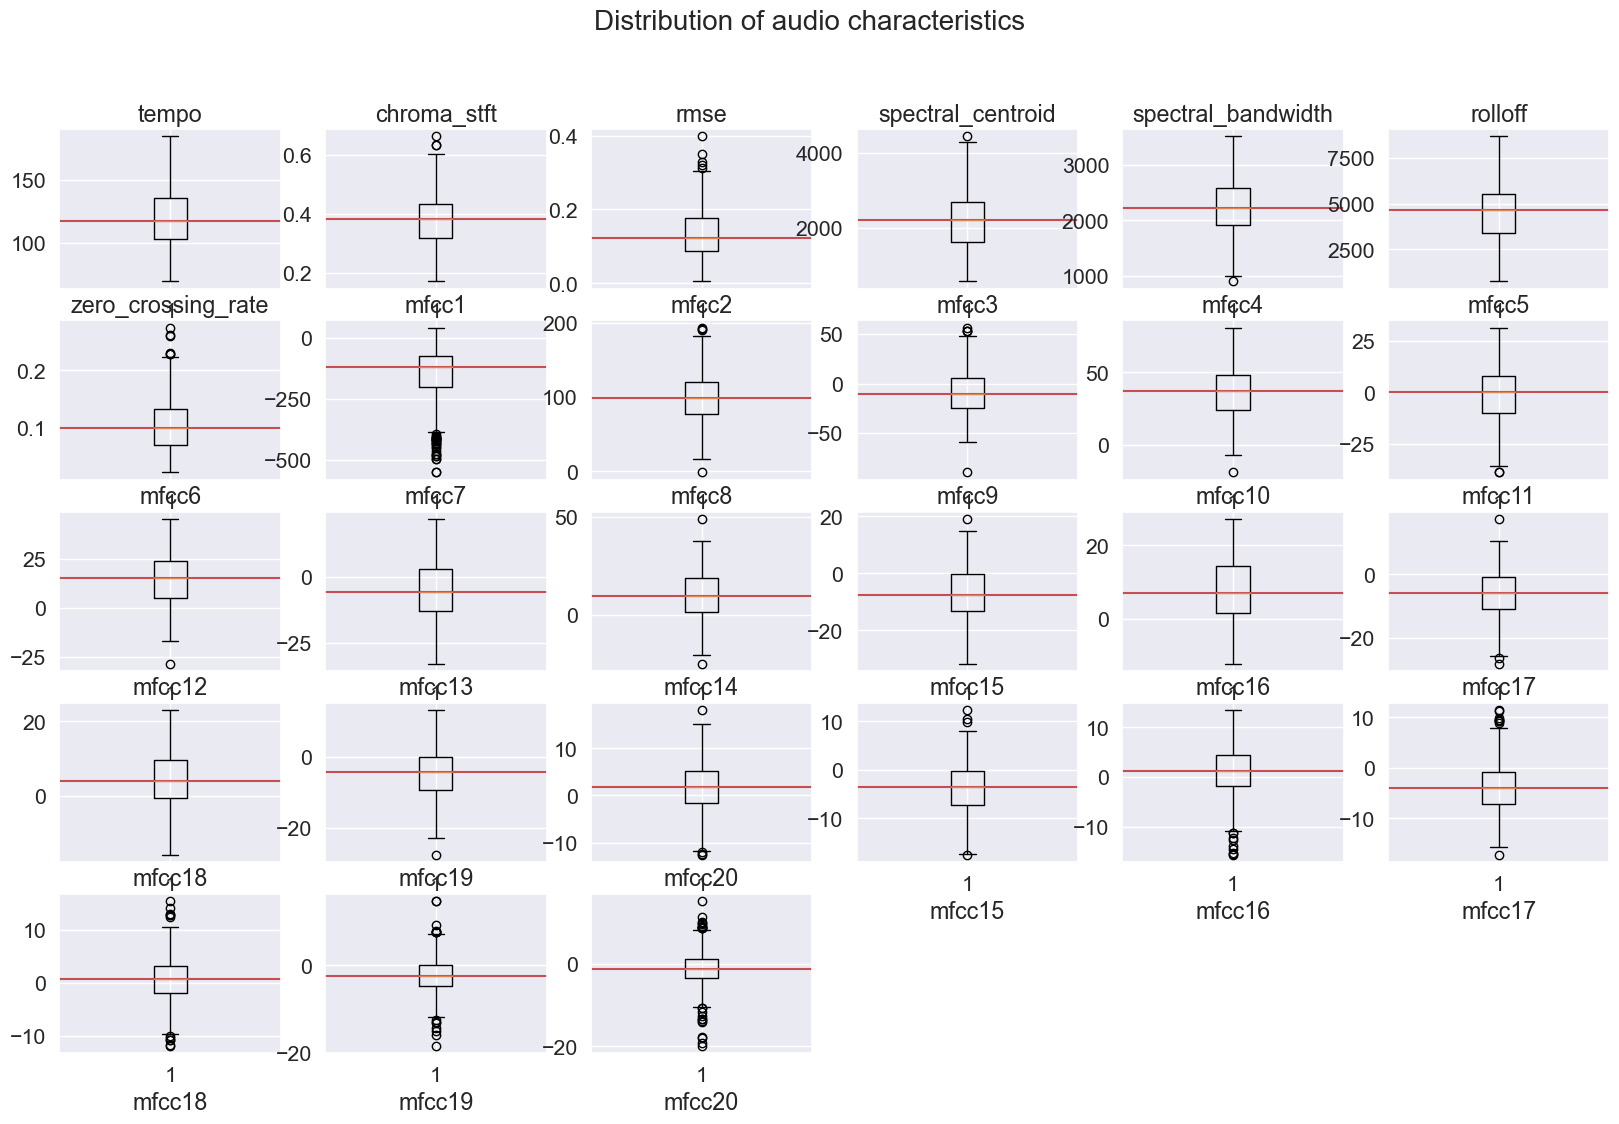

In [53]:

cols_to_plot = list(range(data.shape[1] - 1))
data_to_plot = data.iloc[:, cols_to_plot]


fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 12))
for i, ax in enumerate(axes.flat):
    if i < len(cols_to_plot):
        ax.boxplot(data_to_plot.iloc[:, i])
        ax.set_title(f'{data_to_plot.columns[i]}')
        ax.axhline(y=data_to_plot.iloc[:, i].median(), color='r')
        ax.set_xlabel(data_to_plot.columns[i])
    else:
        ax.set_visible(False)


fig.suptitle('Distribution of audio characteristics', fontsize=20)

plt.show()

In [54]:
def remove_outliers(data, q1=0.25, q3=0.75, iqr_factor=1.5):
    cols_to_process = list(range(data.shape[1] - 1))
    data_to_process = data.iloc[:, cols_to_process]

    thresholds = data_to_process.quantile([q1, q3])
    iqr = iqr_factor * (thresholds.loc[q3] - thresholds.loc[q1])

    for col in data_to_process.columns:
        lower = thresholds.loc[q1, col] - iqr.loc[col]
        upper = thresholds.loc[q3, col] + iqr.loc[col]
        data[col] = np.where((data[col] < lower) | (data[col] > upper),
                                        np.nan,
                                        data[col])

    return data.dropna()

In [55]:
data_clean = remove_outliers(data)
del data
data_clean.shape

(909, 28)

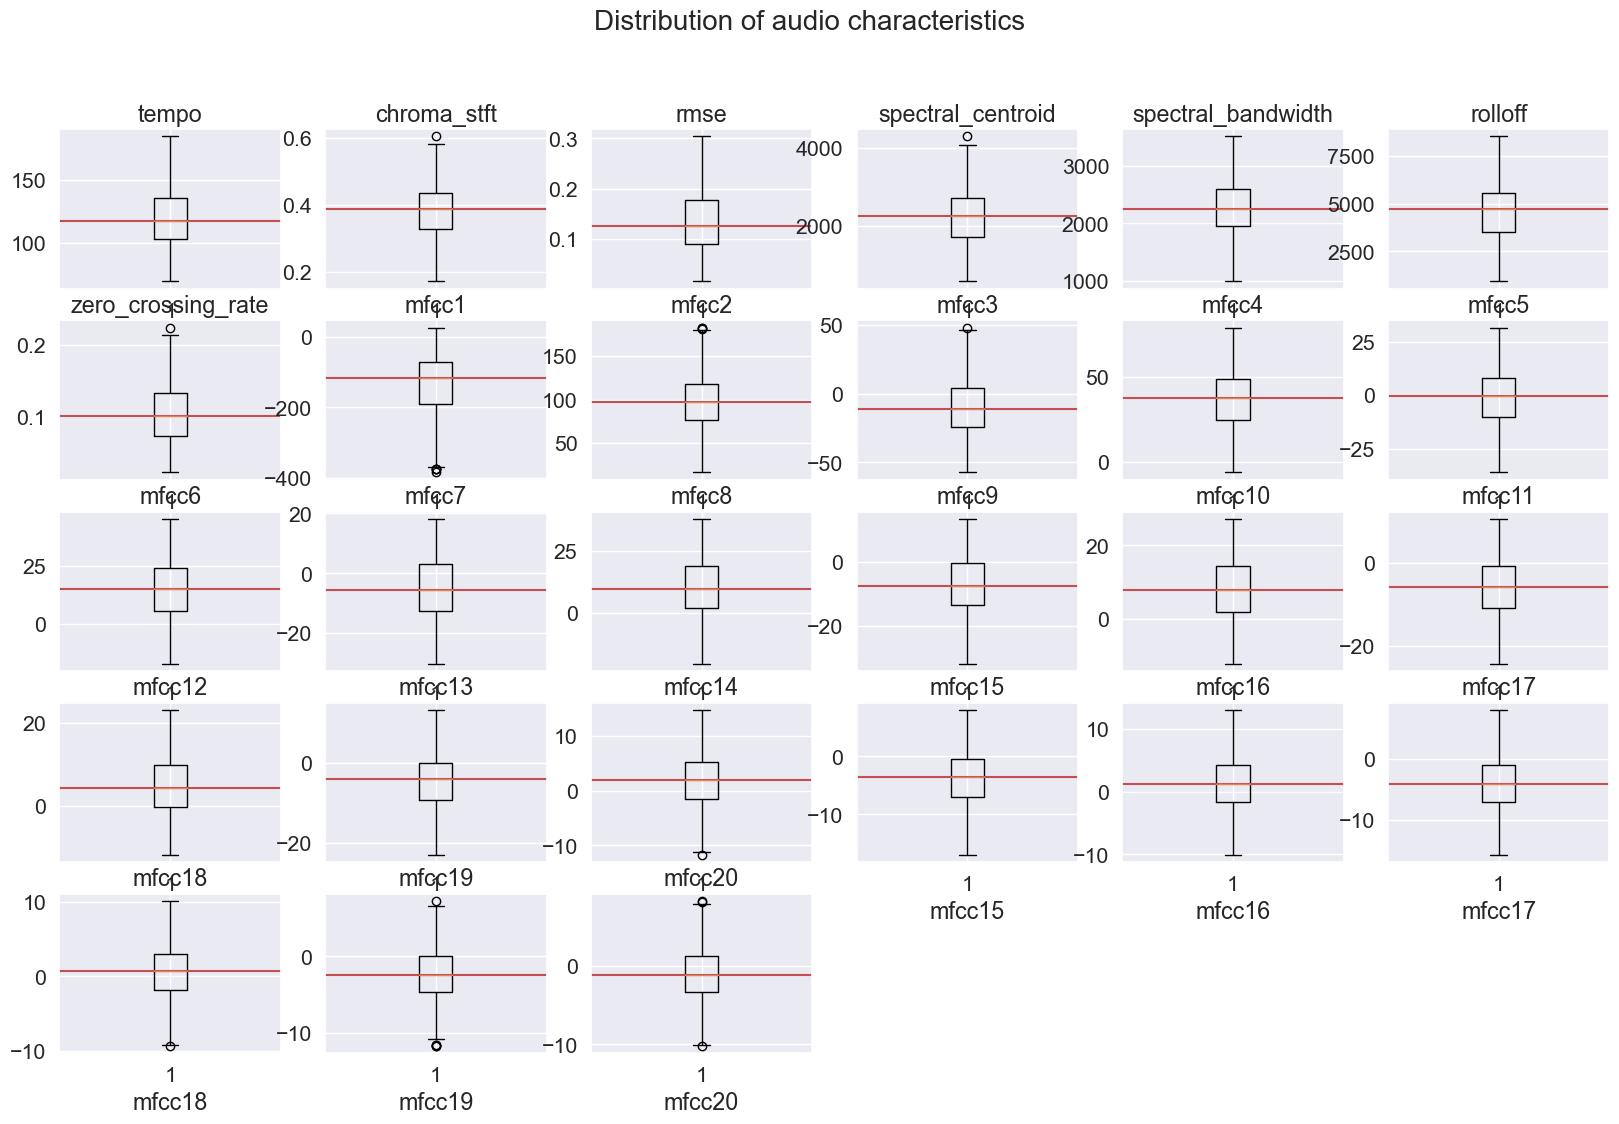

In [56]:
cols_to_plot = list(range(data_clean.shape[1] - 1))
data_to_plot = data_clean.iloc[:, cols_to_plot]

fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 12))
for i, ax in enumerate(axes.flat):
    if i < len(cols_to_plot):
        ax.boxplot(data_to_plot.iloc[:, i])
        ax.set_title(f'{data_to_plot.columns[i]}')
        ax.axhline(y=data_to_plot.iloc[:, i].median(), color='r')
        ax.set_xlabel(data_to_plot.columns[i])
    else:
        ax.set_visible(False)


fig.suptitle('Distribution of audio characteristics', fontsize=20)

plt.show()

C:\Users\mihir\AppData\Local\Temp\ipykernel_6624\2497704200.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data_clean.corr()


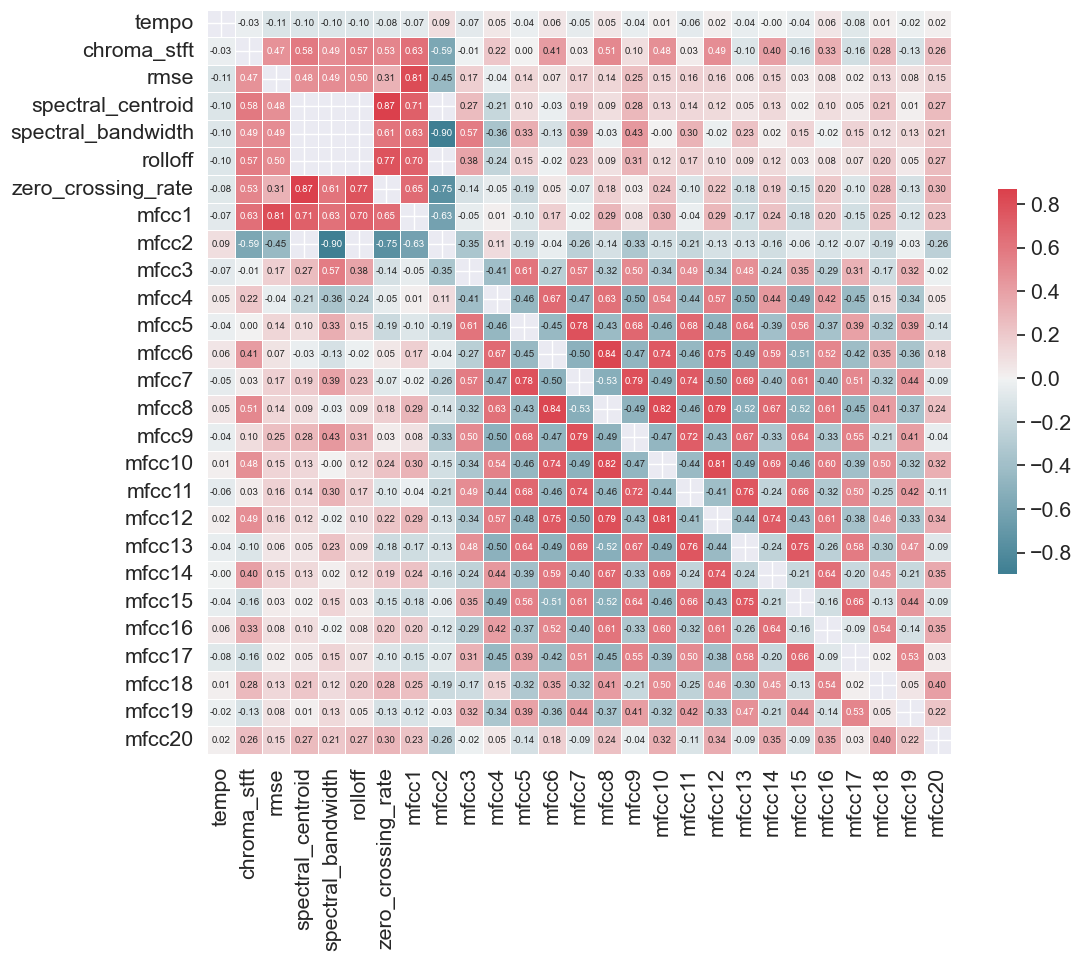

In [57]:
corr = data_clean.corr()

mask = corr.abs() > 0.9

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap=cmap, mask=mask, center=0, square=True, linewidths=.4, annot=True, fmt=".2f", annot_kws={"size": 7}, cbar_kws={"shrink": .5})
plt.show()

In [58]:
X=np.array(data_clean.iloc[:, :-1])

genre_list = data_clean.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train = scaler.fit_transform(np.array(X_train, dtype = float))
X_test = scaler.transform(np.array(X_test, dtype = float))

In [59]:
X_train.shape

(727, 27)

In [60]:
#1 Support vector machine
model_svm = SVC()
model_svm.fit(X_train, y_train)

SVC()

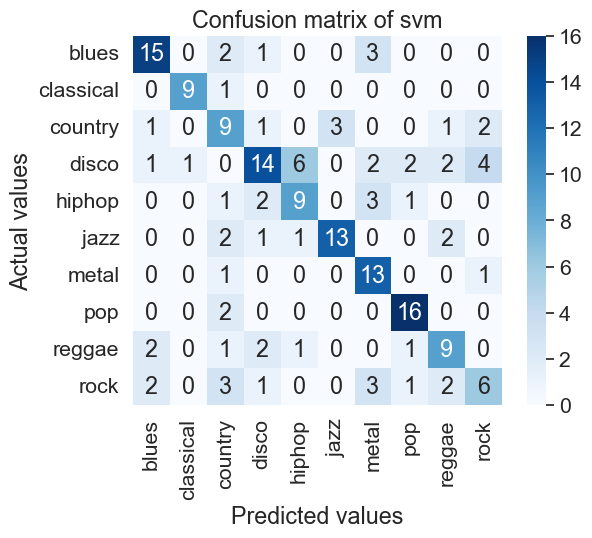

In [61]:
y_pred_svm = model_svm.predict(X_test)

mat = confusion_matrix(y_test, y_pred_svm)


sns.set(font_scale=1.4) 
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Blues",
            xticklabels=genres, yticklabels=genres)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of svm' )
plt.show()

In [84]:
a_svm = accuracy_score(y_test, y_pred_svm)
p_svm = precision_score(y_test,y_pred_svm, average = 'macro')
r_svm = recall_score(y_test,y_pred_svm, average = 'macro')
f1_svm = f1_score(y_test,y_pred_svm, average = 'macro')
print("Precision : ",p_svm)
print("Accuracy: ",a_svm)
print("Recall : ", r_svm)
print("F1-Score : ", f1_svm)


Precision :  0.6329261914556031
Accuracy:  0.6208791208791209
Recall :  0.6479296894196275
F1-Score :  0.6319430644027418


In [63]:
#2 KNN
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

KNeighborsClassifier()

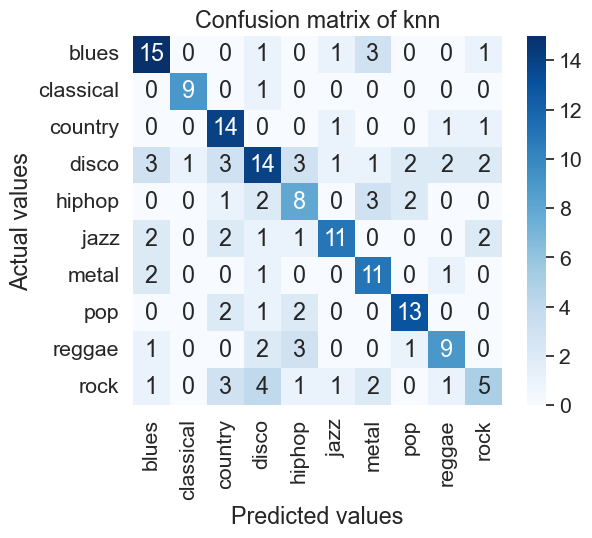

In [64]:
y_pred_knn = model_knn.predict(X_test)

mat = confusion_matrix(y_test, y_pred_knn)


sns.set(font_scale=1.4) 
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Blues",
            xticklabels=genres, yticklabels=genres)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of knn' )
plt.show()

In [85]:
a_knn = accuracy_score(y_test, y_pred_knn)
p_knn = precision_score(y_test,y_pred_knn, average = 'macro')
r_knn = recall_score(y_test,y_pred_knn, average = 'macro')
f1_knn = f1_score(y_test,y_pred_knn, average = 'macro')
print("Precision : ",p_knn)
print("Accuracy: ",a_knn)
print("Recall : ", r_knn)
print("F1-Score : ", f1_knn)

Precision :  0.5989010989010989
Recall :  0.6250095827804806
F1-Score :  0.612117790034385


In [66]:
#3 Naive bayes
model_NB = GaussianNB()
model_NB.fit(X_train, y_train)

GaussianNB()

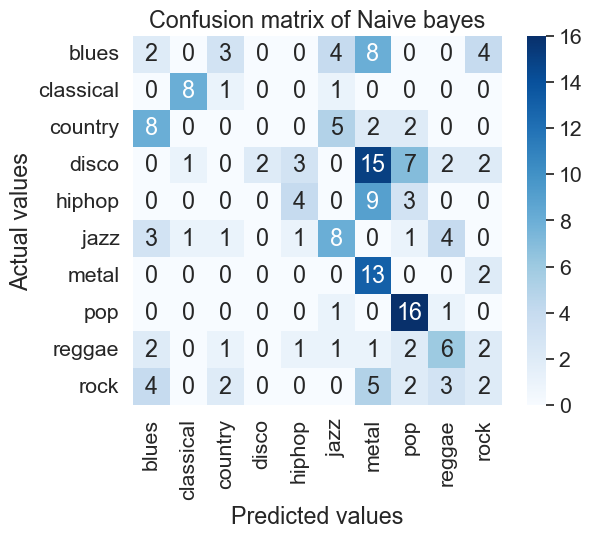

In [67]:
y_pred_NB = model_NB.predict(X_test)

mat = confusion_matrix(y_test, y_pred_NB)
sns.set(font_scale=1.4) 
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Blues",
            xticklabels=genres, yticklabels=genres)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of Naive bayes' )
plt.show()

In [86]:
a_NB = accuracy_score(y_test, y_pred_NB)
p_NB = precision_score(y_test,y_pred_NB, average = 'macro')
r_NB = recall_score(y_test,y_pred_NB, average = 'macro')
f1_NB = f1_score(y_test,y_pred_NB, average = 'macro')
print("Precision : ",p_NB)
print("Accuracy: ",a_NB)
print("Recall : ", r_NB)
print("F1-Score : ", f1_NB)

Precision :  0.33516483516483514
Recall :  0.38704573934837094
F1-Score :  0.32660407239819006


In [69]:
#4 Decision Tree
model_DT = DecisionTreeClassifier()
model_DT.fit(X_train,y_train)

DecisionTreeClassifier()

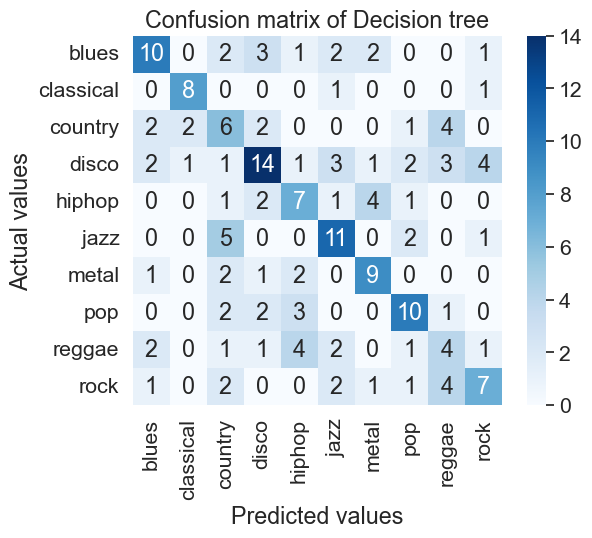

In [70]:
y_pred_DT = model_DT.predict(X_test)

mat = confusion_matrix(y_test, y_pred_DT)


sns.set(font_scale=1.4) 
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Blues",
            xticklabels=genres, yticklabels=genres)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of Decision tree' )
plt.show()

In [90]:
a_DT = accuracy_score(y_test, y_pred_DT)
p_DT = precision_score(y_test,y_pred_DT, average = 'macro')
r_DT = recall_score(y_test,y_pred_DT, average = 'macro')
f1_DT = f1_score(y_test,y_pred_DT, average = 'macro')
print("Precision : ",p_DT)
print("Accuracy: ",a_DT)
print("Recall : ", r_DT)
print("F1-Score : ", f1_DT)

Precision :  0.48060784313725496
Accuracy:  0.4725274725274725
Recall :  0.48775234655265615
F1-Score :  0.4814293704127012


In [72]:
#5 Random Forest

model_rf = RandomForestClassifier(random_state = 42,bootstrap = True)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

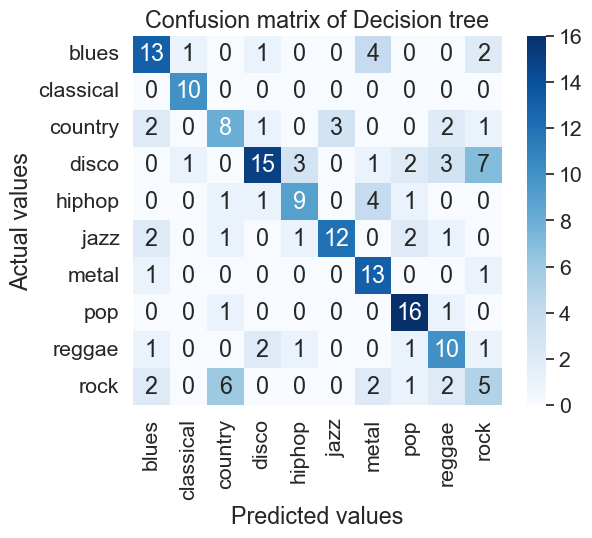

In [73]:
y_pred_rf = model_rf.predict(X_test)

mat = confusion_matrix(y_test, y_pred_rf)


sns.set(font_scale=1.4) 
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Blues",
            xticklabels=genres, yticklabels=genres)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Confusion matrix of Decision tree' )
plt.show()

In [91]:
a_rf = accuracy_score(y_test, y_pred_rf)
p_rf = precision_score(y_test,y_pred_rf, average = 'macro')
r_rf = recall_score(y_test,y_pred_rf, average = 'macro')
f1_rf = f1_score(y_test,y_pred_rf, average = 'macro')
print("Precision : ",p_rf)
print("Accuracy: ",a_rf)
print("Recall : ", r_rf)
print("F1-Score : ", f1_rf)

Precision :  0.6173578607644431
Accuracy:  0.6098901098901099
Recall :  0.6410798135043492
F1-Score :  0.6185829521984472


In [75]:
#6 Artificial Neural network
model_ann = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])
model_ann.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_ann = model_ann.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)

Max. Validation Accuracy 0.6703296899795532


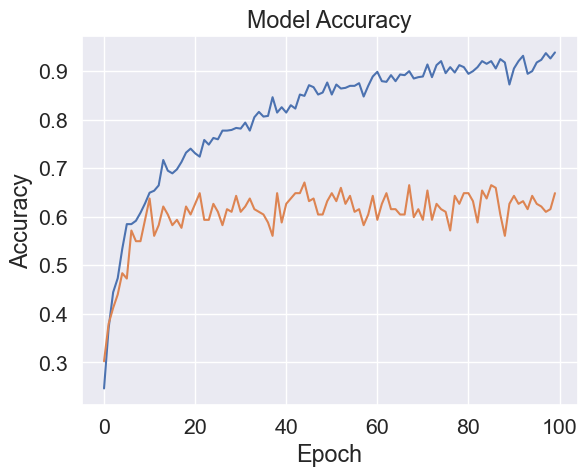

In [76]:
print("Max. Validation Accuracy",max(history_ann.history["val_accuracy"]))
plt.plot(history_ann.history['accuracy'],label="train")
plt.plot(history_ann.history['val_accuracy'],label="test")
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


6/6 [==============================] - 0s 1ms/step


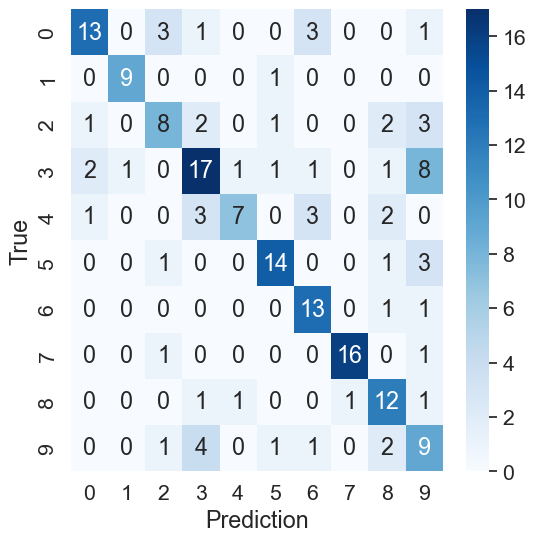

In [77]:
y_pred_ANN = model_ann.predict(X_test)
y_true_classes = np.argmax(y_test.reshape(1,-1), axis=1)
y_pred_classes = np.argmax(y_pred_ANN, axis=1)

confusion_mtx = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6,6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.show()

In [92]:
a_ann = accuracy_score(y_test, y_pred_classes)
p_ann = precision_score(y_test,y_pred_classes, average = 'macro')
r_ann = recall_score(y_test,y_pred_classes, average = 'macro')
f1_ann = f1_score(y_test,y_pred_classes, average = 'macro')
# Print results
print("Precision: ",p_ann)
print("Accuracy: ",a_ann)
print("Recall: ",r_ann)
print("F1 Score:",f1_ann)


Precision:  0.6863818860877683
Accuracy:  0.6483516483516484
Recall:  0.6700783515160451
F1 Score: 0.6668919567153864


In [97]:
model_names = ['SVM', 'KNN', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'Artificial Neural network']
precision_scores = [p_svm,p_knn,p_NB,p_DT,p_rf,p_ann]
accuracy_scores = [a_svm,a_knn,a_NB,a_DT,a_rf,a_ann]
recall_scores = [r_svm,r_knn,r_NB,r_DT,r_rf,r_ann]
f1_scores = [f1_svm,f1_knn,f1_NB,f1_DT,f1_rf,f1_ann]
precision_percentage=[]
accuracy_percentage = []
recall_percentage = []
f1_percentage = []
results_df = pd.DataFrame(columns=['Model', 'Precision'])
for i in range(len(accuracy_scores)):
    p_percentage = round(precision_scores[i] * 100, 2)
    a_percentage = round(accuracy_scores[i] * 100, 2)
    r_percentage = round(recall_scores[i] * 100, 2)
    f1_percentagea = round(f1_scores[i] * 100, 2)
    precision_percentage.append(p_percentage)
    accuracy_percentage.append(a_percentage)
    recall_percentage.append(r_percentage)
    f1_percentage.append(f1_percentagea)
    results_df = results_df.append({'Model': model_names[i], 'Precision':precision_percentage[i],'Accuracy':accuracy_percentage[i],'Recall':recall_percentage[i],'F1 Score':f1_percentage[i]},ignore_index=True)

C:\Users\mihir\AppData\Local\Temp\ipykernel_6624\4056016357.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model_names[i], 'Precision':precision_percentage[i],'Accuracy':accuracy_percentage[i],'Recall':recall_percentage[i],'F1 Score':f1_percentage[i]},ignore_index=True)
C:\Users\mihir\AppData\Local\Temp\ipykernel_6624\4056016357.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model': model_names[i], 'Precision':precision_percentage[i],'Accuracy':accuracy_percentage[i],'Recall':recall_percentage[i],'F1 Score':f1_percentage[i]},ignore_index=True)
C:\Users\mihir\AppData\Local\Temp\ipykernel_6624\4056016357.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

In [98]:
print(results_df)

                       Model  Precision  Accuracy  Recall  F1 Score
0                        SVM      63.29     62.09   64.79     63.19
1                        KNN      61.51     59.89   62.50     61.21
2                Naive Bayes      40.22     33.52   38.70     32.66
3              Decision Tree      48.06     47.25   48.78     48.14
4              Random Forest      61.74     60.99   64.11     61.86
5  Artificial Neural network      68.64     64.84   67.01     66.69
